# Fluent setup and solution using PyFluent APIs
------------------------------------------------
This example sets up and solves a three-dimensional turbulent fluid flow
and heat transfer problem in a mixing elbow, which is common in piping
systems in power plants and process industries. Predicting the flow field
and temperature field in the area of the mixing region is important to
designing the junction properly.

This example uses settings objects.

**Problem description**

A cold fluid at 20 deg C flows into the pipe through a large inlet. It then mixes
with a warmer fluid at 40 deg C that enters through a smaller inlet located at
the elbow. The pipe dimensions are in inches, and the fluid properties and
boundary conditions are given in SI units. Because the Reynolds number for the
flow at the larger inlet is ``50, 800``, a turbulent flow model is required.

###############################################################################
# Perform required imports
# ~~~~~~~~~~~~~~~~~~~~~~~~

In [108]:
import os
from ansys.workbench.core import launch_workbench

In [109]:
import ansys.fluent.core as pyfluent
from ansys.fluent.core import examples
from ansys.fluent.visualization.pyvista import Graphics

# Specify client and server directories and launch WB service (This example launches WB locally)

In [110]:
client_dir = r'D:\users\mvani\PyWB\PyWB-examples\pyfluent_mixing_elbow\client_work_dir'
server_dir = r'D:\users\mvani\PyWB\PyWB-examples\pyfluent_mixing_elbow\server_work_dir'

host = 'localhost'
release = '241'

wb = launch_workbench(release=release, server_workdir=server_dir, client_workdir=client_dir)

# Get the input file from example data and upload to server directory

In [87]:
import_filename = examples.download_file("mixing_elbow.msh.h5", "pyfluent/mixing_elbow")
wb.upload_file(import_filename)

Checking if specified file already exists...
File already exists. File path:
C:\Users\mkvani\AppData\Local\Ansys\ansys_fluent_core\examples\mixing_elbow.msh.h5


Uploading mixing_elbow.msh.h5: 100%|██████████| 2.68M/2.68M [00:00<00:00, 154MB/s]


In [88]:
# run a Workbench script to define the project and load geometry

export_path = os.path.join(client_dir, 'wb_log_file.log')
wb.set_log_file(export_path)
wb.run_script_string('template1 = GetTemplate(TemplateName="FLUENT")', log_level='info')
wb.run_script_string('system1 = template1.CreateSystem()')


{}

###############################################################################
# Launch Fluent
# ~~~~~~~~~~~~~
# Launch Fluent as a service in meshing mode with double precision running on
# two processors.

In [89]:
server_info_file = wb.start_fluent_server(system_name= "FLU")
fluent_session = pyfluent.connect_to_fluent(server_info_filepath= server_info_file)

###############################################################################
# Import mesh and perform mesh check
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Import the mesh and perform a mesh check, which lists the minimum and maximum
# x, y, and z values from the mesh in the default SI units of meters. The mesh
# check also reports a number of other mesh features that are checked. Any errors
# in the mesh are reported. Ensure that the minimum volume is not negative because
# Fluent cannot begin a calculation when this is the case.

In [90]:
import_filename = os.path.join(server_dir, 'mixing_elbow.msh.h5')
fluent_session.file.read(file_type="case", file_name= import_filename)

True

###############################################################################
# Set working units for mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set the working units for the mesh to inches. Because the default SI units are
# used for everything except length, you do not have to change any other units
# in this example. If you want working units for length to be other than inches
# (for example, millimeters), make the appropriate change.

In [91]:
fluent_session.tui.define.units("length", "in")

pyfluent.tui WARNING: Currently calling the TUI commands in a generic manner. Please run `python codegen/allapigen.py` from the top-level pyfluent directory to generate the local TUI commands classes.


###############################################################################
# Enable heat transfer
# ~~~~~~~~~~~~~~~~~~~~
# Enable heat transfer by activating the energy equation.

In [92]:
fluent_session.setup.models.energy.enabled = True

###############################################################################
# Create material
# ~~~~~~~~~~~~~~~
# Create a material named ``"water-liquid"``.

In [93]:
fluent_session.setup.materials.database.copy_by_name(type="fluid", name="water-liquid")

False

###############################################################################
# Set up cell zone conditions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the cell zone conditions for the fluid zone (``elbow-fluid``). Set ``material``
# to ``"water-liquid"``.

In [94]:
fluent_session.setup.cell_zone_conditions.fluid["elbow-fluid"].material = "water-liquid"

###############################################################################
# Set up boundary conditions for CFD analysis
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the boundary conditions for the inlets, outlet, and walls for CFD
# analysis.

# cold inlet (cold-inlet), Setting: Value:
# Velocity Specification Method: Magnitude, Normal to Boundary
# Velocity Magnitude: 0.4 [m/s]
# Specification Method: Intensity and Hydraulic Diameter
# Turbulent Intensity: 5 [%]
# Hydraulic Diameter: 4 [inch]
# Temperature: 293.15 [K]

In [95]:
cold_inlet = fluent_session.setup.boundary_conditions.velocity_inlet["cold-inlet"]

In [96]:
cold_inlet.get_state()


{'name': 'cold-inlet',
 'momentum': {'velocity_specification_method': 'Magnitude, Normal to Boundary',
  'reference_frame': 'Absolute',
  'velocity': {'option': 'value', 'value': 0},
  'initial_gauge_pressure': {'option': 'value', 'value': 0}},
 'turbulence': {'turbulent_specification': 'Intensity and Viscosity Ratio',
  'turbulent_intensity': 0.05,
  'turbulent_viscosity_ratio_real': 10},
 'thermal': {'t': {'option': 'value', 'value': 300}}}

In [97]:
cold_inlet.momentum.velocity.value = 0.4
cold_inlet.turbulence.turbulent_specification = "Intensity and Hydraulic Diameter"
cold_inlet.turbulence.turbulent_intensity = 0.05
cold_inlet.turbulence. hydraulic_diameter = "4 [in]"
cold_inlet.thermal.t.value = 293.15

# hot inlet (hot-inlet), Setting: Value:
# Velocity Specification Method: Magnitude, Normal to Boundary
# Velocity Magnitude: 1.2 [m/s]
# Specification Method: Intensity and Hydraulic Diameter
# Turbulent Intensity: 5 [%]
# Hydraulic Diameter: 1 [inch]
# Temperature: 313.15 [K]

In [98]:
hot_inlet = fluent_session.setup.boundary_conditions.velocity_inlet["hot-inlet"]

hot_inlet.momentum.velocity.value = 1.2
hot_inlet.turbulence.turbulent_specification = "Intensity and Hydraulic Diameter"
hot_inlet.turbulence.turbulent_intensity = 0.05
hot_inlet.turbulence. hydraulic_diameter = "1 [in]"
hot_inlet.thermal.t.value = 313.15

# pressure outlet (outlet), Setting: Value:
# Backflow Turbulent Intensity: 5 [%]
# Backflow Turbulent Viscosity Ratio: 4

In [99]:
fluent_session.setup.boundary_conditions.pressure_outlet["outlet"].turbulence.turbulent_viscosity_ratio_real = 4

# Set 150 iterations for solution

In [100]:
fluent_session.solution.run_calculation.iter_count = 150

# Update Solution using WB Journal Command

In [101]:
wb.run_script_string("system1 = GetSystem(Name=\"FLU\")")
wb.run_script_string("solutionComponent1 = system1.GetComponent(Name=\"Solution\")")
wb.run_script_string("solutionComponent1.Update(AllDependencies=True)")

{}

###############################################################################
# Create velocity vectors
# ~~~~~~~~~~~~~~~~~~~~~~~
# Create and display velocity vectors on the ``symmetry-xyplane`` plane

###############################################
# Post processing with PyVista (3D visualization)
# =============================================

d:\users\mvani\PyWB\PyWB-examples\pyworkbench-examples\pywb_env\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


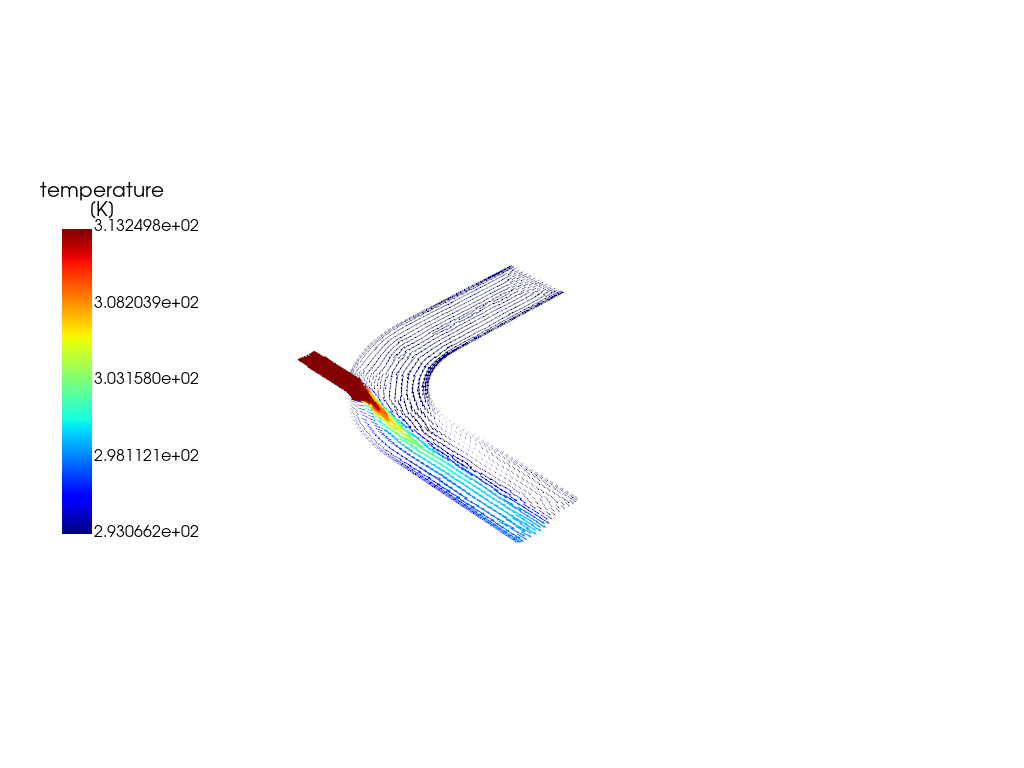

In [102]:
graphics_session_vec = Graphics(fluent_session)
velocity_vector = graphics_session_vec.Vectors["velocity-vector"]
velocity_vector.field = "temperature"
velocity_vector.surfaces_list = ["symmetry-xyplane"]
velocity_vector.scale = 2
velocity_vector.display()

###############################################################################
# Compute mass flow rate
# ~~~~~~~~~~~~~~~~~~~~~~
# Compute the mass flow rate.

In [103]:
fluent_session.solution.report_definitions.flux["mass_flow_rate"] = {}

mass_flow_rate = fluent_session.solution.report_definitions.flux["mass_flow_rate"]
mass_flow_rate.boundaries = [
    "cold-inlet",
    "hot-inlet",
    "outlet",
]
mass_flow_rate.print_state()
fluent_session.solution.report_definitions.compute(report_defs=["mass_flow_rate"])


name : mass_flow_rate
report_type : flux-massflow
boundaries : 
  0 : cold-inlet
  1 : hot-inlet
  2 : outlet
per_zone : False
average_over : 1
phase : mixture
retain_instantaneous_values : False


[{'mass_flow_rate': [-5.424022674560547e-06, 0]}]

# Save project

In [104]:
file_path = os.path.join(server_dir, "mixing_elbow.wbpj")
save_string = "Save(FilePath=\"" + file_path + "\"," + "Overwrite=True)"
# wb.run_script_string('Save(FilePath="mixing_elbow1.wbpj", Overwrite=True)')
wb.run_script_string(save_string)


{}

In [105]:
file_path = os.path.join(server_dir, "mixing_elbow.wbpz")
archive_string = "Archive(FilePath=\"" + file_path + "\")"
wb.run_script_string(archive_string)

{}

# Download the WB archived project

In [111]:
wb.download_file("mixing_elbow.wbpz")

'mixing_elbow.wbpz'

In [106]:
fluent_session.exit()

In [107]:
wb.exit()